### Estimating the effect of a public policy on Brazilian students

On this notebook we'll try to explore the idea of estimating the impact of a public policy that pays scolarship for public schools students to

The following approaches will be tried:

- Logistic Regression
- Bayesian Network
- Structured Causal Model

We're going to make classes from the continuous features. The target will be adjusted to be 1 when it's above 80% of the scores and 0 otherwise. 

Since the idea here is just to illustrate, most of the features are going to be discarded. 

The ones intended to be keeped are:

Students characteristics:
- Age (NU_IDADE)
- Region (transformed SG_UF_RESIDENCIA)
- Gender (TP_SEXO)
- School (TP_ESCOLA)
- Skin color (TP_COR_RACA)
- Monthly Income (Q006)

Variables to filter examples:
- Presença na prova objetiva de Ciências da Natureza (TP_PRESENCA_CN)
- Presença na prova objetiva de Ciências Humanas (TP_PRESENCA_CH)
- Presença na prova objetiva de Linguagens e Códigos (TP_PRESENCA_LC)
- Presença na prova objetiva de Matemática (TP_PRESENCA_MT)

Variables of interest:
- Sciences grade (NU_NOTA_CN)
- Human Sciences grade (NU_NOTA_CH)
- Language grade (NU_NOTA_LC)
- Math grade (NU_NOTA_MT)
- Writing grade (NU_NOTA_REDACAO)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
colunas = ['NU_IDADE',
           #'SG_UF_RESIDENCIA',
           'TP_SEXO',
           'TP_ESCOLA',
           'TP_COR_RACA',
           'Q006',
           'NU_NOTA_CH',
           'NU_NOTA_CN', 
           'NU_NOTA_LC', 
           'NU_NOTA_MT',
           'NU_NOTA_REDACAO',
           'TP_PRESENCA_CN', 
           'TP_PRESENCA_CH',
           'TP_PRESENCA_LC', 
           'TP_PRESENCA_MT'] 

In [3]:
data = pd.read_csv("data/microdados_enem_2016_coma.csv", encoding='latin-1', 
                 sep=',', usecols=colunas)

/opt/conda/envs/causal/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.shape

(8627367, 14)

In [5]:
data.head()

,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ESCOLA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q006
0,23.0,M,3,1,1,1.0,1.0,1.0,550.0,629.4,574.0,462.9,580.0,B
1,20.0,M,1,1,1,1.0,1.0,1.0,576.6,669.8,610.1,423.6,560.0,D
2,21.0,M,3,1,1,1.0,1.0,1.0,485.8,576.9,637.4,414.6,480.0,D
3,17.0,M,1,1,1,1.0,1.0,1.0,571.4,628.6,646.2,709.4,620.0,B
4,36.0,F,1,1,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,A


### Cleaning

Exclude:
- Students that are not from public schoold neither from private
- Students that were eliminated in one of the tests
- Students that didn't attended one of the tests

In [6]:
data = data[data["TP_ESCOLA"].isin([2, 3])]
data["PRIVATE_SCHOOL"] = (data["TP_ESCOLA"] == 3).astype(int)
data.shape

(1881291, 15)

We're going to exclude the students that didn't one of the tests.

Yes, it's going to bias the data, let's check the hypothesis that students from public schools tend to not do the test.

In [7]:
data["PRESENCA_EM_TODAS"] = 0
data.loc[(data[["TP_PRESENCA_MT", "TP_PRESENCA_LC", "TP_PRESENCA_CH", "TP_PRESENCA_CN"]] == 1).all(axis=1) ,"PRESENCA_EM_TODAS"] = 1
data.groupby("PRESENCA_EM_TODAS").mean()["PRIVATE_SCHOOL"]

PRESENCA_EM_TODAS
0    0.148571
1    0.226505
Name: PRIVATE_SCHOOL, dtype: float64

Indeed, between the group that did all the tests the students from private schools represent 22%, while in the one from prople who didn't attend at least one of the tests they represent ~15%.

In [8]:
data = data[data["PRESENCA_EM_TODAS"] == 1]
data.shape

(512098, 16)

In [9]:
print("Working with {} examples".format(len(data)))
print("The dataset contains {} columns.".format(data.shape[1]))

Working with 512098 examples
The dataset contains 16 columns.


## Preprocessing features

We're going to categorize all the features.

Also we want to have.


- Age (NU_IDADE): Create 5 quantile bins
- Region (transformed SG_UF_RESIDENCIA): No transform
- Gender (TP_SEXO): No transform
- School (TP_ESCOLA): No transform
- Skin color (TP_COR_RACA): No transform
- Monthly Income (Q006): No transform

Variables of interest:
- Sciences grade (NU_NOTA_CN)
- Human Sciences grade (NU_NOTA_CH)
- Language grade (NU_NOTA_LC)
- Math grade (NU_NOTA_MT)
- Writing grade (NU_NOTA_REDACAO)

In [10]:
def one_hot_encoder(df, nan_as_category = True, verbose=False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    if verbose:
        for col in categorical_columns:
            print("{} has {} unique values".format(col, len(df[col].unique())))
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [11]:
### 1 if white 0 othereise
data["TP_COR_RACA"] = data["TP_COR_RACA"].apply(lambda x : 1 if x == 1 else 0)
data["TP_SEXO"] = data["TP_SEXO"].apply(lambda x : 1 if x == "M" else 0)

In [12]:
data["TP_COR_RACA"] = data["TP_COR_RACA"].astype("object")

In [13]:
data.dtypes

NU_IDADE             float64
TP_SEXO                int64
TP_COR_RACA           object
TP_ESCOLA              int64
TP_PRESENCA_CN        object
TP_PRESENCA_CH       float64
TP_PRESENCA_LC       float64
TP_PRESENCA_MT       float64
NU_NOTA_CN           float64
NU_NOTA_CH           float64
NU_NOTA_LC           float64
NU_NOTA_MT           float64
NU_NOTA_REDACAO      float64
Q006                  object
PRIVATE_SCHOOL         int64
PRESENCA_EM_TODAS      int64
dtype: object

In [14]:
data.columns

Index(['NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q006',
       'PRIVATE_SCHOOL', 'PRESENCA_EM_TODAS'],
      dtype='object')

In [15]:
data["TOTAL_NOTA"] = data[['NU_NOTA_CH',
                           'NU_NOTA_CN', 
                           'NU_NOTA_LC', 
                           'NU_NOTA_MT',
                           'NU_NOTA_REDACAO']].sum(axis=1)

Text(0.5, 1.0, 'TOTAL_NOTA distribution')

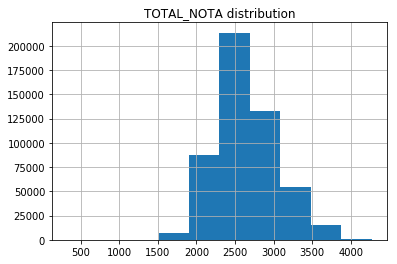

In [16]:
### Checking score distribution
data["TOTAL_NOTA"].hist()
plt.title("TOTAL_NOTA distribution")

In [17]:
data.rename(columns={"Q006": "MONTHLY_INCOME"}, inplace=True)

In [18]:
from string import ascii_lowercase

label_dict = {}
for i, c in enumerate(ascii_lowercase):
    label_dict[c.upper()] = i    

In [19]:
data["MONTHLY_INCOME"] = data["MONTHLY_INCOME"].apply(lambda x : label_dict.get(x, 0))

Age:


In [20]:
reg_data, new_columns = one_hot_encoder(data[["TP_SEXO",
                                        #  "SG_UF_RESIDENCIA",
                                          "NU_IDADE",
                                          "TP_COR_RACA",
                                          "PRIVATE_SCHOOL",
                                          "MONTHLY_INCOME",
                                          "TOTAL_NOTA"]])

### Mean difference

In [22]:
grouped_data = data.groupby("PRIVATE_SCHOOL").mean()["TOTAL_NOTA"]
grouped_data

PRIVATE_SCHOOL
0    2540.608546
1    2993.670986
Name: TOTAL_NOTA, dtype: float64

In [23]:
print("So we can say that the average difference in grade is {:.2f}.".format(grouped_data[1] - grouped_data[0]))

So we can say that the average difference in grade is 453.06.


### Linear Regression

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [25]:
features = ['NU_IDADE',
            'PRIVATE_SCHOOL'] + new_columns

target = "TOTAL_NOTA"

In [26]:
features

['NU_IDADE',
 'PRIVATE_SCHOOL',
 'TP_COR_RACA_0.0',
 'TP_COR_RACA_1.0',
 'TP_COR_RACA_nan']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(reg_data[features], 
                                                    reg_data[target],
                                                    test_size=0.2,
                                                    random_state=42)

In [28]:
for feature in features:
    X_train[feature].fillna(X_train[feature].median(), inplace=True)
    X_test[feature].fillna(X_train[feature].median(), inplace=True)

In [29]:
print("Training data shape: {}".format(X_train.shape))
print("Training target shape {}".format(y_train.shape))

Training data shape: (409678, 5)
Training target shape (409678,)


In [30]:
model = LinearRegression(normalize=True)

In [31]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [32]:
print("Checking the model predictability power. r2 = {:.2f}".format(r2_score(y_test, model.predict(X_test))))

Checking the model predictability power. r2 = 0.26


In [33]:
model.coef_

array([-1.91473346e+01,  3.81287497e+02, -3.92532383e+15, -3.92532383e+15,
        0.00000000e+00])

In [34]:
print("The linear regression tells us the impact would be {:.2f}".format(model.coef_[1]))

The linear regression tells us the impact would be 381.29


### Causal Structured Model

In [35]:
import dowhy
from dowhy.do_why import CausalModel

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
def label_encode(df):
    
    label_encoding_columns = [col for col in df.columns if df[col].dtype == 'object']
    print("Label encoding: ")
    for col in label_encoding_columns:
        print(col)
        le = LabelEncoder()

        ### Calc mode in the trainset
        mode = df[col].mode().values[0]

        ### Fill na with mode
        df[col].fillna(mode, inplace=True)

        ### Fit with test to catch new classes
        le.fit(df[col])

        ###
        df[col] = le.transform(df[col])

    return df

Label Encoding is bad for Regression (if there's no ordering to be encoded), but here it'd be a pain to use OHE and connect all nodes

In [38]:
scm_data = label_encode(data)

Label encoding: 
TP_COR_RACA
TP_PRESENCA_CN


```
[('PRIVATE_SCHOOL', 'TP_SEXO'),
 ('PRIVATE_SCHOOL', 'MONTHLY_INCOME'),
 ('TP_SEXO', 'TOTAL_NOTA'),
 ('TP_SEXO', 'TP_COR_RACA'),
 ('TP_SEXO', 'NU_IDADE')]
```
 
```
[('PRIVATE_SCHOOL', 'NU_IDADE'),
 ('PRIVATE_SCHOOL', 'TP_SEXO'),
 ('TP_SEXO', 'TOTAL_NOTA'),
 ('MONTHLY_INCOME', 'TP_COR_RACA'),
 ('MONTHLY_INCOME', 'PRIVATE_SCHOOL')]
```

```
[('PRIVATE_SCHOOL', 'TP_COR_RACA'),
 ('PRIVATE_SCHOOL', 'NU_IDADE'),
 ('PRIVATE_SCHOOL', 'TP_SEXO'),
 ('TP_SEXO', 'MONTHLY_INCOME'),
 ('TP_COR_RACA', 'TOTAL_NOTA')]
 ```

### Using the learned network from BN

In [50]:
features = ["TP_SEXO",
            "NU_IDADE",
            "TP_COR_RACA",
            "PRIVATE_SCHOOL",
            "MONTHLY_INCOME"]

target = "TOTAL_NOTA"

scm_data = scm_data[features + [target]]

In [64]:
for feature in features + [target]:
    scm_data[feature].fillna(scm_data[feature].median(), inplace=True)

/opt/conda/envs/causal/lib/python3.5/site-packages/pandas-0.23.4-py3.5-linux-x86_64.egg/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [51]:
# With graph
model=CausalModel(
        data = scm_data,
        treatment="PRIVATE_SCHOOL",
        outcome="TOTAL_NOTA",
        graph="""graph[directed 1 node[id "PRIVATE_SCHOOL" label "PRIVATE_SCHOOL"]
                    node[id "TOTAL_NOTA" label "TOTAL_NOTA"]
                    node[id "MONTHLY_INCOME" label "MONTHLY_INCOME"]
                    node[id "NU_IDADE" label "NU_IDADE"]
                    node[id "TP_SEXO" label "TP_SEXO"]                    
                    node[id "TP_COR_RACA" label "TP_COR_RACA"]                    
                    edge[source "MONTHLY_INCOME" target "PRIVATE_SCHOOL"]
                    edge[source "MONTHLY_INCOME" target "TP_COR_RACA"]                    
                    edge[source "MONTHLY_INCOME" target "TOTAL_NOTA"]                                        
                    edge[source "PRIVATE_SCHOOL" target "TP_SEXO"]
                    edge[source "PRIVATE_SCHOOL" target "NU_IDADE"]
                    edge[source "TP_SEXO" target "NU_IDADE"]                    
                    edge[source "TP_SEXO" target "TP_COR_RACA"]
                    edge[source "TOTAL_NOTA" target "TP_SEXO"]
                    edge[source "TOTAL_NOTA" target "NU_IDADE"]
                    edge[source "TOTAL_NOTA" target "PRIVATE_SCHOOL"]                    
                    ]"""
        )        

Model to find the causal effect of treatment PRIVATE_SCHOOL on outcome TOTAL_NOTA


Using Matplotlib for plotting


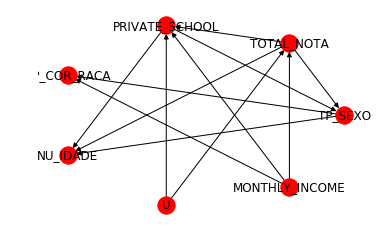

In [52]:
model.view_model()

In [53]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'MONTHLY_INCOME'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
       d                                               
───────────────(Expectation(TOTAL_NOTA|MONTHLY_INCOME))
dPRIVATE_SCHOOL                                        
Estimand assumption 1, Unconfoundedness: If U→PRIVATE_SCHOOL and U→TOTAL_NOTA then P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME,U) = P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME)



#### Method 1 - Regression

In [54]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
       d                                               
───────────────(Expectation(TOTAL_NOTA|MONTHLY_INCOME))
dPRIVATE_SCHOOL                                        
Estimand assumption 1, Unconfoundedness: If U→PRIVATE_SCHOOL and U→TOTAL_NOTA then P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME,U) = P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME)

## Realized estimand
b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME
## Estimate
Value: 273.37862381027827

## Statistical Significance
p-value: 0.0

Causal Estimate is 273.37862381027827


#### Propesity score stratification

In [55]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME


PropensityScoreStratificationEstimator


/opt/conda/envs/causal/lib/python3.5/site-packages/dowhy-0.1.0-py3.5.egg/dowhy/causal_estimators/propensity_score_stratification_estimator.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/causal/lib/python3.5/site-packages/dowhy-0.1.0-py3.5.egg/dowhy/causal_estimators/propensity_score_stratification_estimator.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/causal/lib/python3.5/site-packages/dowhy-0.1.0-py3.5.egg/dowhy/causal_estimators/propensity_score_stratification_estimator.py:44: SettingWithCopyWarni

*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
       d                                               
───────────────(Expectation(TOTAL_NOTA|MONTHLY_INCOME))
dPRIVATE_SCHOOL                                        
Estimand assumption 1, Unconfoundedness: If U→PRIVATE_SCHOOL and U→TOTAL_NOTA then P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME,U) = P(TOTAL_NOTA|PRIVATE_SCHOOL,MONTHLY_INCOME)

## Realized estimand
b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME
## Estimate
Value: 283.847668010267

Causal Estimate is 283.847668010267


#### Robustness

Three tests to see how robusts the results are:

1 - Add a Random Common Cause and measure the effect again (it should be similar)
2 - Add a placebo treatment (the effect shouldn't be similar)
3 - Use a subset of the data (the effect should be similar)

In [56]:
res_random=model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME+w_random


Refute: Add a Random Common Cause
Estimated effect:(273.37862381027827,)
New effect:(273.37822553781507,)



In [57]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~placebo+MONTHLY_INCOME


Refute: Use a Placebo Treatment
Estimated effect:(273.37862381027827,)
New effect:(1.062726378241203,)



In [58]:
res_subset=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~PRIVATE_SCHOOL+MONTHLY_INCOME


Refute: Use a subset of data
Estimated effect:(273.37862381027827,)
New effect:(273.11101911385384,)



### Changing the causal direction

In [59]:
# With graph
model=CausalModel(
        data = scm_data,
        treatment="PRIVATE_SCHOOL",
        outcome="TOTAL_NOTA",
        graph="""graph[directed 1 node[id "PRIVATE_SCHOOL" label "PRIVATE_SCHOOL"]
                    node[id "TOTAL_NOTA" label "TOTAL_NOTA"]
                    node[id "MONTHLY_INCOME" label "MONTHLY_INCOME"]
                    node[id "NU_IDADE" label "NU_IDADE"]
                    node[id "TP_SEXO" label "TP_SEXO"]                    
                    node[id "TP_COR_RACA" label "TP_COR_RACA"]                    
                    edge[source "MONTHLY_INCOME" target "PRIVATE_SCHOOL"]
                    edge[source "TP_COR_RACA" target "MONTHLY_INCOME"]  
                    edge[source "TP_COR_RACA" target "PRIVATE_SCHOOL"]                                        
                    edge[source "MONTHLY_INCOME" target "TOTAL_NOTA"]                                        
                    edge[source "TP_SEXO" target "NU_IDADE"]                    
                    edge[source "TP_SEXO" target "TP_COR_RACA"]
                    edge[source "TP_SEXO" target "TOTAL_NOTA"]
                    edge[source "TP_SEXO" target "PRIVATE_SCHOOL"]   
                    edge[source "NU_IDADE" target "PRIVATE_SCHOOL"]                    
                    edge[source "NU_IDADE" target "TOTAL_NOTA"]                                        
                    edge[source "PRIVATE_SCHOOL" target "TOTAL_NOTA"]                    
                    ]"""
        )        

Model to find the causal effect of treatment PRIVATE_SCHOOL on outcome TOTAL_NOTA


Using Matplotlib for plotting


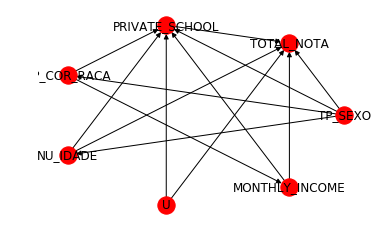

In [60]:
model.view_model()

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'U', 'TP_COR_RACA', 'NU_IDADE', 'MONTHLY_INCOME', 'TP_SEXO'}


{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] n


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(TOTAL_NOTA|TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_
dPRIVATE_SCHOOL                                                               

      
SEXO))
      
Estimand assumption 1, Unconfoundedness: If U→PRIVATE_SCHOOL and U→TOTAL_NOTA then P(TOTAL_NOTA|PRIVATE_SCHOOL,TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_SEXO,U) = P(TOTAL_NOTA|PRIVATE_SCHOOL,TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_SEXO)



In [65]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: TOTAL_NOTA~PRIVATE_SCHOOL+TP_COR_RACA+NU_IDADE+MONTHLY_INCOME+TP_SEXO


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(TOTAL_NOTA|TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_
dPRIVATE_SCHOOL                                                               

      
SEXO))
      
Estimand assumption 1, Unconfoundedness: If U→PRIVATE_SCHOOL and U→TOTAL_NOTA then P(TOTAL_NOTA|PRIVATE_SCHOOL,TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_SEXO,U) = P(TOTAL_NOTA|PRIVATE_SCHOOL,TP_COR_RACA,NU_IDADE,MONTHLY_INCOME,TP_SEXO)

## Realized estimand
b: TOTAL_NOTA~PRIVATE_SCHOOL+TP_COR_RACA+NU_IDADE+MONTHLY_INCOME+TP_SEXO
## Estimate
Value: 264.9364558171889

## Statistical Significance
p-value: 0.0

Causal Estimate is 264.9364558171889


### Bayesian Network

In [63]:
import pgmpy
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore

In [64]:
df = data.sample(frac=1)

In [65]:
df["NU_IDADE"] = pd.cut(df["NU_IDADE"], bins=10).astype("object")
df["TOTAL_NOTA"] = pd.cut(df["TOTAL_NOTA"], bins=10).astype("object")

In [66]:
df["NU_IDADE"].unique()

array(['(39.2, 46]', '(11.932, 18.8]', '(32.4, 39.2]', '(18.8, 25.6]',
       '(25.6, 32.4]', '(46, 52.8]', '(52.8, 59.6]', '(59.6, 66.4]',
       '(66.4, 73.2]', nan, '(73.2, 80]'], dtype=object)

In [73]:
df["TOTAL_NOTA"].unique()

array(['(1905.14, 2299.4]', '(2299.4, 2693.66]', '(2693.66, 3087.92]',
       '(3087.92, 3482.18]', '(3482.18, 3876.44]', '(1510.88, 1905.14]',
       '(3876.44, 4270.7]', '(1116.62, 1510.88]', '(722.36, 1116.62]',
       '(324.157, 722.36]'], dtype=object)

In [74]:
df = label_encode(df)

Label encoding: 
NU_IDADE
TP_COR_RACA
TP_PRESENCA_CN
TOTAL_NOTA


In [75]:
features = ['MONTHLY_INCOME',
            'PRIVATE_SCHOOL'] #+ new_columns

features = ["TP_SEXO",
            "NU_IDADE",
            "TP_COR_RACA",
            "PRIVATE_SCHOOL",
            "MONTHLY_INCOME"]

target = "TOTAL_NOTA"

In [76]:
df = df[features + [target]]
df[features + [target]].head()

,TP_SEXO,NU_IDADE,TP_COR_RACA,PRIVATE_SCHOOL,MONTHLY_INCOME,TOTAL_NOTA
1708387,0,4,1,0,2,2
2136526,1,0,1,0,1,3
1173924,0,0,1,0,4,3
1600404,1,0,0,0,2,4
1526702,0,3,1,0,4,3


In [77]:
model = HillClimbSearch(df[features+[target]],
                        scoring_method=BicScore(df[features + [target]]))

In [78]:
%%time
best_model = model.estimate()

CPU times: user 41.4 s, sys: 23.5 ms, total: 41.4 s
Wall time: 41.7 s


In [79]:
# import networkx as nx

# nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
# plt.show()

In [80]:
best_model.edges()

[('TOTAL_NOTA', 'NU_IDADE'),
 ('TOTAL_NOTA', 'PRIVATE_SCHOOL'),
 ('TOTAL_NOTA', 'TP_SEXO'),
 ('MONTHLY_INCOME', 'TOTAL_NOTA'),
 ('MONTHLY_INCOME', 'TP_COR_RACA'),
 ('MONTHLY_INCOME', 'PRIVATE_SCHOOL'),
 ('PRIVATE_SCHOOL', 'NU_IDADE'),
 ('PRIVATE_SCHOOL', 'TP_COR_RACA'),
 ('PRIVATE_SCHOOL', 'TP_SEXO'),
 ('TP_SEXO', 'TP_COR_RACA'),
 ('TP_SEXO', 'NU_IDADE')]

In [81]:
from pgmpy.estimators import BayesianEstimator
estimator = BayesianEstimator(best_model, df[features + [target]])

In [82]:
best_model.fit(df[features + [target]])

In [83]:
from pgmpy.inference import VariableElimination
enem_infer = VariableElimination(best_model)

In [84]:
best_model.get_cpds()

[<TabularCPD representing P(MONTHLY_INCOME:17) at 0x7f2c4255a390>,
 <TabularCPD representing P(NU_IDADE:10 | PRIVATE_SCHOOL:2, TOTAL_NOTA:10, TP_SEXO:2) at 0x7f2c4255a898>,
 <TabularCPD representing P(PRIVATE_SCHOOL:2 | MONTHLY_INCOME:17, TOTAL_NOTA:10) at 0x7f2c4254c3c8>,
 <TabularCPD representing P(TOTAL_NOTA:10 | MONTHLY_INCOME:17) at 0x7f2c4254ce10>,
 <TabularCPD representing P(TP_COR_RACA:2 | MONTHLY_INCOME:17, PRIVATE_SCHOOL:2, TP_SEXO:2) at 0x7f2c424f6c50>,
 <TabularCPD representing P(TP_SEXO:2 | PRIVATE_SCHOOL:2, TOTAL_NOTA:10) at 0x7f2cc7e88470>]

In [85]:
for cpd in best_model.get_cpds():
    print(cpd)

╒════════════════════╤════════════╕
│ MONTHLY_INCOME(0)  │ 0.0223024  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(1)  │ 0.218872   │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(2)  │ 0.222596   │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(3)  │ 0.119438   │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(4)  │ 0.0904964  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(5)  │ 0.0626443  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(6)  │ 0.0724764  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(7)  │ 0.0496272  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(8)  │ 0.0350616  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(9)  │ 0.0237103  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(10) │ 0.0137552  │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(11) │ 0.00778367 │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(12) │ 0.00902952 │
├────────────────────┼────────────┤
│ MONTHLY_INCOME(13) │ 0.015

In [86]:
q = enem_infer.query(variables=['TOTAL_NOTA'], evidence={'PRIVATE_SCHOOL': 0})
print(q['TOTAL_NOTA'])

╒══════════════╤═══════════════════╕
│ TOTAL_NOTA   │   phi(TOTAL_NOTA) │
╞══════════════╪═══════════════════╡
│ TOTAL_NOTA_0 │            0.0004 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_1 │            0.0174 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_2 │            0.2105 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_3 │            0.4790 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_4 │            0.2328 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_5 │            0.0533 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_6 │            0.0000 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_7 │            0.0063 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_8 │            0.0002 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_9 │            0.0001 │
╘══════════════╧═══════════════════╛


In [88]:
q2 = enem_infer.query(variables=['TOTAL_NOTA'], evidence={'PRIVATE_SCHOOL': 1})
print(q2['TOTAL_NOTA'])

╒══════════════╤═══════════════════╕
│ TOTAL_NOTA   │   phi(TOTAL_NOTA) │
╞══════════════╪═══════════════════╡
│ TOTAL_NOTA_0 │            0.0001 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_1 │            0.0017 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_2 │            0.0340 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_3 │            0.2046 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_4 │            0.3499 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_5 │            0.2895 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_6 │            0.0000 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_7 │            0.1110 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_8 │            0.0091 │
├──────────────┼───────────────────┤
│ TOTAL_NOTA_9 │            0.0001 │
╘══════════════╧═══════════════════╛


In [99]:
# ['(1905.14, 2299.4]', '(2299.4, 2693.66]', '(2693.66, 3087.92]',
#        '(3087.92, 3482.18]', '(3482.18, 3876.44]', '(1510.88, 1905.14]',
#        '(3876.44, 4270.7]', '(1116.62, 1510.88]', '(722.36, 1116.62]',
#        '(324.157, 722.36]']
mean_grades = np.array([525, 925, 1350, 1725, 2125, 2525, 2925, 3325, 3725, 4125])

In [102]:
q1_vector = q['TOTAL_NOTA'].values
q2_vector = q2['TOTAL_NOTA'].values

In [104]:
np.dot(q2_vector, mean_grades) - np.dot(q1_vector, mean_grades)

500.14787938075733